# Hyperparameter Tuning 

```{admonition} Authors:
[Mehrad Ansari](https://github.com/mehradans92)
```

As you have learned so far, there are number of optimization algorithms to train deep learning models. Training a complex deep learning model can take hours, days or even weeks. Therefore, random guesses for model's hyperparameters might not be very practical and some deeper knowledge is required. These hyperparameters include but are not limited to learning rate, number of hidden layers, dropout rate, batch size and number of epochs to train for. Notably, not all these hyperparameters contribute in the same way to the model's performance, which makes finding the best configurations of these variables in such high dimensional space a nontrivial challenge (searching is expensive!). In this chapter, we look at different strategies to tackle this searching problem.

```{admonition} Audience & Objectives
This chapter builds on {doc}`layers` and {doc}`../ml/classification`. After completing this chapter, you should be able to 

  * Distinguish between training and model design-related hyperparamters 
  * Understand the importance of validation data in hyperparameter tuning  
  * Understand how each hyperparameter can affect model's performance
```

Hyperparameters can be categorized into two groups: those used for training and those related to model structure and design.

## Training Hyperparameters

### Learning rate

Gradient descent algorithms multiply the gradient by a scalar known as learning rate to determine the next point in the weights' space. Learning rate is a hyperparameter that controls the step size to move in the direction of lower loss function, with the goal of minimizing it. In most cases, learning rate is manually adjusted during model training. Large learning rates ($\alpha$) make the model learn faster but at the same time it may cause us to miss the minimum loss function and only reach the surrounding of it. In cases where the learning rate is too large, the optimizer overshoots the minimum and the loss updates will lead to divergent behaviours. On the other hand, choosing lower $\alpha$ values gives a better chance of finding the local minima with the trade-off of needing larger number of epochs and more time. 


```{figure} ./loss-lr.gif
----
name: loss_lr
width: 1000px
----
Effect of learning rate on loss. 
```
    
Note that we can almost never plot the loss as a function of weight's space (as shown in {numref}`loss_lr`), and this makes finding the reasonable $\alpha$ tricky.  With a proper constant $\alpha$, the model can be trained to a passable yet still unsatisfactory accuracy, because the constant $\alpha$ can be overlarge, especially in the last few epochs. Alternatively, $\alpha$ can be adaptively adjusted in response to the performance of the model. This is also known as learning rate decay schedule. Some commonly applied decay schedules include linear (step), exponential, polynomial and cyclic. By starting at a larger learning rate, we achieve the rarely discussed benefit of allowing our model to escape the local minima that overfits, and find a broader minimum as learning rate decreases over the number of epochs. If you are using {obj}`Keras`, you can either define your own scheduler or use any from [{obj}`tf.keras.optimizers.schedules`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules) and add it as a callback when you train your model. Some other adaptive learning rate schedulers that might help with reducing tuning efforts can be found in {cite}`khodamoradi2021aslr,yang2020pacl,vidyabharathi2021achieving`.


```{figure} ./decay.gif
----
name: decay_lr
width: 750px
----
Decay schedules on learning rate can possibly help escaping the local minima. 
```

### Momentum

Another tweak that can help escaping the local minima is the addition of the history to the weight update. "The momentum algorithm accumulates an exponentially decaying moving average of past gradients and continues to move in their direction" {cite}`goodfellow2017deep`. Simply speaking, this means that rather than using only the gradient of the current step to guide the search in the weights' space, momentum also accumulates the gradient of the past steps to determine which direction to go to. Momentum has the effect of smoothing the optimization process, allowing for slower updates to continue in the previous directions instead of oscillating or getting stuck. Momentum has a value greater than zero and less than one, but common values used in practice range between 0.9 and 0.99. Note that momentum is rarely changed in deep learning as a hyperparameter, as it does not really help with configuring the proper learning rate. Instead, it can increase the speed of the optimization process by increasing the likelihood of obtaining a better set of weights in fewer training epochs.

### Batch Size

The batch size is always a trade-off between computational efficiency and accuracy. By reducing the batch size, you are essentially reducing the number of samples based on which loss is calculated at each training iteration. Considering model evaluation metrics, smaller batch sizes generalize well on the unobserved data in validation and test set. But why do large batch sizes result a poorer generalization? [This thread](https://stats.stackexchange.com/questions/164876/what-is-the-trade-off-between-batch-size-and-number-of-iterations-to-train-a-neu) on Stack Exchange has some great hypotheses:

- Gradient descent-based optimization makes linear approximation of the loss function, and this approximation will not be the best for highly non-linear loss functions, thus, having a smaller batch size helps.
- Large-batch training methods are shown to converge to sharp minimizers of the training and testing functions, and that sharp minima results poorer generalization {cite}`keskar2016large,hoffer2017train,lin2020extrapolation`.
- Since smaller samples can have more variations from one another, they can add more noise to convergence. Thus, by keeping the batch size small, we are more likely to escape the local minima and find a more broader one.



As mentioned in the previous section, decaying the learning rate is a common practice in training ML frameworks. But, it has actually been shown that we can obtain the same benefits and learning curve by scaling up the batch size during training instead {cite}`smith2017don`.

## Model Design-Related Hyperparameters

### Number of hidden layers

The overall structure of neural networks are determined based on the number of hidden layers ($d$). Before describing this, let us talk about the traditional disagreement on how the total number of layers are counted. This disagreement centers around whether or not the input layer is counted. There is an argument that suggests it should not be counted since inputs are not active. We go by this convention, which is also recommended in {cite}`reed1999neural`. A single-layer can only be used to represent linearly separable functions, in very simple problems. On the other hand, deep learning models with more layers are more likely to capture more complex features are obtain a relative higher accuracy. As a common sense, you can keep adding layers until the test error does not improve anymore.

### Number of nodes in each hidden layer

The number of nodes ($w$) in each layer should be carefully considered to avoid overfitting and underfitting. Small ($w$) may result underfitting as the model lacks complexity. On the other hand, too many nodes (large $w$) can cause overfitting and increase training time. Here are some [rules-of-thumb](https://www.heatonresearch.com/2017/06/01/hidden-layers.html) that can be a good start for tuning the number of nodes:

1. $w_{input}$ $<$ $w$ $<$ $w_{output}$

2. $w = \frac{2}{3}w_{input}$ $+$ $w_{output}$

3. $w < 2 w_{output}$

### Regularization

Regularization is applied to counteract the additional model complexity that comes as a result of adding more nodes in deep neural networks. The most common regularization methods ($L_1$ and $L_2$) are explained in {doc}`../ml/regression`. Hyperparameter $\lambda$ determines the magnitude of the regularization term in the loss function. Too large $\lambda$ pushes the weights closer to zero and oversimplifies the structure of the deep learning model, where as undersized $\lambda$ is not strong enough to reduce the weights. Thanks to its computational efficiency $L_2$ regularization is more widely used, however, $L_1$ regularization prevails over $L_2$ on sparse properties. A brief comparison between $L_1$ and  $L_2$ are presented in the table below.


|                         $L_1$                        |                  $L_2$                 |
|:--------------------------------------------------:|:-----------------------------------:|
| Penalizes the sum of the absolute value of weights | Penalizes the sum of square weights |
|          Unable to learn complex patterns          | Able to learn complex data patterns |
|                 Robust to outliers                 |        Not robust to outliers       |
|             Built-in feature selection             |         No feature selection        |
|                  Multiple solution                 |             One solution            |
|                   Sparse solution                  |          Nonsparse solution         |
    

## Hyperparameter Optimization

Mathematically, hyperparameter optimization (HPO) is the process of finding the set of hyperparamters to either achieve minimum loss or maximum accuracy of the objective model. The general philosophy is the same for all HPO algorithms: determine which hyperparameters to tune and their corresponding search space, adjust them from coarse to fine and obtain the optimal combination.

The state-of-the-art HPO algorithms are classified into two categories: search algorithms and trial schedulers. In general, search algorithms are applied for sampling and trial schedulers deal with the early stopping methods for model evaluation.

### Search Algorithms 

#### Grid Search
As long as you have sufficient computational resources, grid search is a straightforward method for HPO. It performs an exhaustive search on the hyperparameters sets defined by the user. Grid search is applicable for cases where we have limited number of hyperparameters with limited search space.

#### Random Search

Random search is a more effective version of grid search but still computationally exhaustive. It performs a randomized search over hyperparameters from certain distributions over possible parameter values. The searching process continues until the desired accuracy is reached or unitl the predetermined computational budget is exhausted. Random search works better than grid search considering two benefits: First, a budget can be assigned independently based on the distribution of the search space, whereas in grid search the budget for each hyperparameter set is a fixed value. This makes random search perform better than grid search, especially in search patterns where some hyperparameters are not uniformly distributed. Secondly, a larger time consumption of random search quite certainly will lead to a larger probability finding the best hyperparameter set (this is known as Monte Carlo techniques).

#### Bayesian Optimization

Bayesian optimization (BO) is a sequential model-based optimization that aims at becoming less wrong with more data by finding the global optimum by balancing exploration and exploitation that minimizes the number of trials. BO outperforms random and grid search in two aspects: 1. There is no need to have some preliminary knowledge of the distribution of hyperparameters. 2. Unlike random and grid search, the posterior probability is obtained based of a relevant search space, meaning that the algorithm discards the hyperparameter ranges that will most likely not deliver promising solutions according to the previous trials. 3. Another remarkable advantage is that BO is applicable to different settings, where the derivative of the objective function is unknown or expensive to calculate, whether it is stochastic or discrete, or convex or non-convex.

BO consists of two key ingredients: 1. A Bayesian probability surrogate model to model the expensive objective function. A **surrogate** mother is a women who agrees to bear a child for another person, so in context, a surrogate function is a less expensive approximation of the objective function. A popular surrogate model for BO are Gaussian processes (GPs).
2. An acquisition function that acts as a metric function to determine the next optimal sampling point. This is where BO provides a balanced trade-off between exploitation and exploration. Exploitation means sampling where the surrogate model predicts a high objective,  given the current available solutions. Exploration means sampling at locations where the prediction uncertainty is high. These both correspond to high acquisition function values, and the goal is to determine the next sampling point by maximizing the acquisition function.


### Trial Schedulers

HPO is a time-consuming process and in realistic scenarios, it is necessary to obtain the best hyperparameter with limited available resources. When it comes to training the hyperparameters by hand, by experience we can narrow the search space down, evaluate the model during training and decide whether to stop the training or keep going. An early stopping strategy tries to mimic this behavior and maximize the computational resource budget for promising hyperparameter sets.

#### Median Stopping

Median stopping is a straightforward early termination policy that makes the stopping decision based on the average primary metrics, such as accuracy or loss reported by previous runs. A trial $X$ is halted at step $S$ if the best objective value by step $S$ is strictly worse than the median value of the running average of all completed trials objective values reported at step $S$ {cite}`golovin2017google`.

#### Curve Fitting

Curve Fitting is another early stopping algorithm rule that predicts the final accuracy or loss using a performance curve regressed from a set of completed or partially completed trials {cite}`domhan2015speeding`. A trial $X$ will be stopped at step $S$ if the extrapolation of the learning curves is worse than the tolerant value of the optimal in the trial history. Unlike median stopping, where we don't have any hyperparameters, curve fitting is a model with parameters and it also requires a training process.



#### Successive Halving

Successive Halving (SHA) converts the hyperparameter optimization problem into a non-stochastic best-arm identification and tries to allocate more resources only to those hyperparameter sets that are more promising {cite}`jamieson2016non`. In SHA, user defines and fixed budget ($B$) and a fixed number of trials ($n$). The hyperparameter sets are uniformly queried for a portion of the intial budget and the corresponding model performances are evaluated for all trials. The worst promising half is dropped while the budget is doubled for the other half and this is done successively until one trial remains. One drawback of SHA is how resources are allocated. There is a trade-off between the total budget ($B$) and number of trials ($n$). If $n$ is too large, each trial may result in premature termination, whereas too small $n$ would not provide enough optional choices.  

Compared with Bayesian optimization, SHA is easier to understand and it is more computationally efficient as it evaluate the intermediate model results and determines whether to terminate it or not. 

#### HyperBand

HyperBand is an extension of SHA that tries to solve the resource allocation problem by considering several possible $n$ values and fixing $B$ {cite}`hyperband`.

## Running This Notebook


Click the &nbsp;<i aria-label="Launch interactive content" class="fas fa-rocket"></i>&nbsp; above to launch this page as an interactive Google Colab. See details below on installing packages, either on your own environment or on Google Colab

````{tip} My title
:class: dropdown
To install packages, execute this code in a new cell

```
!pip install dmol-book
```

````

## Hyperparameter Tuning 

Now that we know more about different HPO techniques, we develop a deep learning model to predict hemolysis in peptides and tune its hyperparameters. Hemolysis is defined as the disruption of erythrocyte membranes that decrease the life span of red blood cells and causes the release of Hemoglobin. Identifying hemolytic antimicrobial is critical to their applications as non-toxic and safe measurements against bacterial infections. However, distinguishing between hemolytic and non-hemolytic peptides is complicated, as they primarily exert their activity at the charged surface of the bacterial plasma membrane. Timmons and Hewage {cite}`timmons2020happenn` differentiate between the two whether they are active at the zwitterionic eukaryotic membrane, as well as the anionic prokaryotic membrane. The model for hemolytic prediction is trained using data from the Database of Antimicrobial Activity and Structure of Peptides (DBAASP v3 {cite}`pirtskhalava2021dbaasp`). The activity is defined by extrapolating a measurement assuming a dose response curves to the point at which 50\% of red blood cells (RBC) are lysed. If the activity is below $100\frac{\mu g}{ml}$, it is considered hemolytic. Each measurement is treated independently, so sequences can appear multiple times. The training data contains 9,316 positive and negative sequences of only L- and canonical amino acids.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import warnings
import urllib
import dmol

In [2]:
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/hemo-positive.npz",
    "positive.npz",
)
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/hemo-negative.npz",
    "negative.npz",
)
with np.load("positive.npz") as r:
    pos_data = r[list(r.keys())[0]]
with np.load("negative.npz") as r:
    neg_data = r[list(r.keys())[0]]

# create labels and stich it all into one
# tensor
labels = np.concatenate(
    (
        np.ones((pos_data.shape[0], 1), dtype=pos_data.dtype),
        np.zeros((neg_data.shape[0], 1), dtype=pos_data.dtype),
    ),
    axis=0,
)
features = np.concatenate((pos_data, neg_data), axis=0)
# we now need to shuffle before creating TF dataset
# so that our train/test/val splits are random
i = np.arange(len(labels))
np.random.shuffle(i)
labels = labels[i]
features = features[i]
full_data = tf.data.Dataset.from_tensor_slices((features, labels))

2022-06-08 00:10:46.711725: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software/zmq/4.2.3/b1/lib:/software/git/2.30.1/lib64:/software/gcc/7.3.0/lib64:/software/gcc/7.3.0/lib:/software/openmpi/4.0.4/b1/lib:/software/cuda/11.2.2/usr/local/cuda-11.2/lib64:/software/cuda/11.2.2/usr/local/cuda-11.2/targets/x86_64-linux/lib:/software/cudnn/11.2-8.1.1/lib64:/software/slurm/current/lib64:/software/slurm/current/lib
2022-06-08 00:10:46.711788: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
def build_model(reg=0.1, add_dropout=False):
    model = tf.keras.Sequential()
    # make embedding and indicate that 0 should be treated specially
    model.add(
        tf.keras.layers.Embedding(
            input_dim=21, output_dim=16, mask_zero=True, input_length=pos_data.shape[-1]
        )
    )

    # now we move to convolutions and pooling
    model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation="relu"))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=4))

    model.add(
        tf.keras.layers.Conv1D(
            filters=16,
            kernel_size=3,
            activation="relu",
        )
    )
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

    model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu"))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

    # now we flatten to move to hidden dense layers.
    # Flattening just removes all axes except 1 (and implicit batch is still in there as always!)

    model.add(tf.keras.layers.Flatten())
    if add_dropout:
        model.add(tf.keras.layers.Dropout(0.3))
    model.add(
        tf.keras.layers.Dense(
            256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(reg)
        )
    )
    if add_dropout:
        model.add(tf.keras.layers.Dropout(0.3))
    model.add(
        tf.keras.layers.Dense(
            64, activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(reg)
        )
    )
    if add_dropout:
        model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    return model

In [4]:
model = build_model(reg=0, add_dropout=False)
# now split into val, test, train
N = pos_data.shape[0] + neg_data.shape[0]
print(N, "examples")
split = int(0.1 * N)
test_data = full_data.take(split).batch(64)
nontest = full_data.skip(split)
val_data, train_data = nontest.take(split).batch(64), nontest.skip(split).shuffle(
    1000
).batch(64)

9316 examples


In [5]:
def train_model(
    model, lr=1e-3, Reduced_LR=False, Early_stop=False, batch_size=32, epochs=20
):

    tf.keras.backend.clear_session()
    callbacks = []

    if Early_stop:
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor="val_auc",
            mode="max",
            patience=5,
            min_delta=1e-2,
            restore_best_weights=True,
        )
        callbacks.append(early_stopping)
    opt = tf.optimizers.Adam(lr)
    if Reduced_LR:
        # decay learning rate on plateau
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.9, patience=5, min_lr=1e-5
        )
        # add a callback to print lr at the begining of every epoch
        callbacks.append(reduce_lr)
    model.compile(
        opt,
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.AUC(from_logits=False),
            tf.keras.metrics.BinaryAccuracy(threshold=0.5),
        ],
    )
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=callbacks,
    )
    #     print(
    #         f"Train Loss: {history.history['loss'][-1]:.3f}, Test Loss: {history.history['val_loss'][-1]:.3f}"
    #     )
    return history


def plot_losses(history, test_data):
    plt.figure(dpi=100)
    plt.plot(history.history["loss"], label="training")
    plt.plot(history.history["val_loss"], label="validation")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    result = model.evaluate(test_data, verbose=0)
    print(f" Test AUC: {result[1]:.3f}  Test Accuracy: {result[2]:.3f}")

So if you take a look at the {obj}`train_model` function defined above, we are using the validation data **exclusively** for the hyperparameter search. The test data is only used in {obj}`plot_losses` and gives us an estimation on model's generalization error.

### Baseline Model

We first start off with a baseline model with similar structure to the model used in {doc}`layers`.

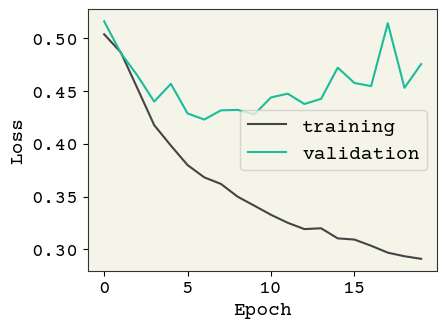

 Test AUC: 0.775  Test Accuracy: 0.829


In [6]:
history = train_model(model, Reduced_LR=False)
plot_losses(history, test_data)

So with the default hyperparameters, the **baseline** model above is clearly ovefitting to the training data. We first try adding l2 regularization:

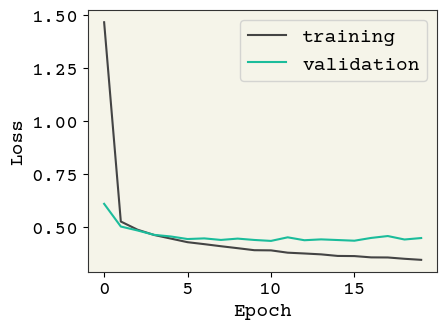

 Test AUC: 0.817  Test Accuracy: 0.828


In [7]:
model = build_model(reg=0.01, add_dropout=False)
history = train_model(model, Reduced_LR=False, Early_stop=False)
plot_losses(history, test_data)

Great! Now We have a lower test loss and better AUC.

 ### Early Stopping

We can use early stopping regularization and return best weights based on maximum obtained AUC value for the **validation data**. This is done by adding the early stopping callback, when compiling the model:

In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_auc", mode="max", patience=5, min_delta=1e-2, restore_best_weights=True
)

Let's see how the model performs with early stopping:

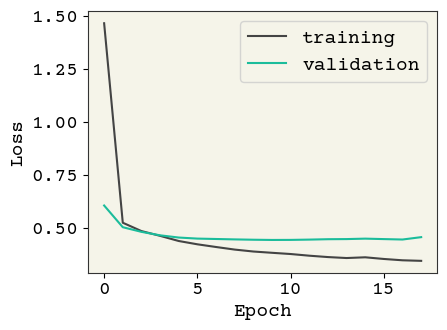

 Test AUC: 0.779  Test Accuracy: 0.820


In [9]:
model = build_model(reg=0.01, add_dropout=False)
history = train_model(model, Reduced_LR=False, Early_stop=True)
plot_losses(history, test_data)

We have almost the same performance but in **fewer** number of epochs. Note that for learning purposes, we have limited the number of epochs to $20$ in this example. Early stopping regularization becomes more relevant when we typically have a large number of epochs, as it halts the training and saves computational budget, unless there is gain in more training.

 ### Reduced Learning Rate on Plateau and Dropout
 
 Now let's try reducing the learning rate and dropout. Since the training epochs is already limited to $20$, we don't use early stopping here:

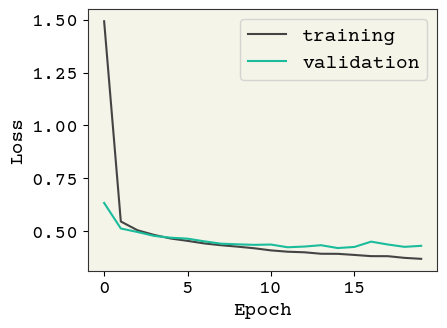

 Test AUC: 0.806  Test Accuracy: 0.824


In [10]:
model = build_model(reg=0.01, add_dropout=True)
history = train_model(model, Reduced_LR=True, Early_stop=False, epochs=20)
plot_losses(history, test_data)

## Discussion

In this chapter, we explored means of reducing overfitting and enhancing feature selection in deep learning models. Techniques suggested can give you a good head start on tuning your model's hyperparameters. What is important is that, you need to experiment to find a good set of hyperparameters. This can be time-consuming, so use your own judgment and intuition to come up with a smart search strategy. Before you start hypertuning, make sure you obtain a baseline model and slowly add more pieces to the puzzle, based on training and validation loss, AUC or other metrics.

There are also some toolkits for hyperparameter optimization that might be handy:

- [Ray Tune for PyTorch](https://www.heatonresearch.com/2017/06/01/hidden-layers.html) {cite}`liaw2018tune`
- [Keras-Tuner for Keras](https://keras.io/keras_tuner/) {cite}`omalley2019kerastuner`
- [Optuna](https://optuna.org/) {cite}`optuna_2019`
- [Hyperopt](https://github.com/hyperopt/hyperopt) {cite}`bergstra2013making`
- [Scikit-Optimize](https://scikit-optimize.github.io/stable/auto_examples/hyperparameter-optimization.html) {cite}`louppe2017bayesian`
- [Microsoft's Neural Network Intelligence](https://github.com/Microsoft/nni) 
- [Google's Vizer](https://cloud.google.com/ai-platform/optimizer/docs/overview) {cite}`golovin2017google`

## Cited References

```{bibliography}
:style: unsrtalpha
:filter: docname in docnames
```